In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import nivapy3 as nivapy
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
def target_plot(mod, obs, ax=None, title=None):
    """ Target plot comparing normalised bias and normalised, unbiased RMSD between two 
        datasets (usually modelled versus observed). Based on code written by Leah 
        Jackson-Blake for the REFRESH project and described in the REFRESH report as 
        follows:
        
            "The y-axis shows normalised bias between simulated and observed. The 
             x-axis is the unbiased, normalised root mean square difference (RMSD) 
             between simulated and observed data. The distance between a point and the
             origin is total RMSD. RMSD = 1 is shown by the solid circle (any point 
             within this has positively correlated simulated and observed data and 
             positive Nash Sutcliffe scores); the dashed circle marks RMSD = 0.7. 
             Normalised unbiased root mean squared deviation is a useful way of 
             comparing standard deviations of the observed and modelled datasets."
             
        See Joliff et al. (2009) for full details:
        
            https://www.sciencedirect.com/science/article/pii/S0924796308001140
            
    Args:
        mod:   Array-like. 1D array or list of modelled values
        obs:   Array-like. 1D array or list of observed/reference values
        ax:    Matplotlib axis or None. Optional. Axis on which to plot, if desired
        title: Str. Optional. Title for plot
             
    Returns:
        Tuple (normalised_bias, normalised_unbiased_rmsd). Plot is created.
    """
    import numpy as np
    import scipy.stats as st
    import pandas as pd
    import matplotlib.pyplot as plt
    
    assert len(mod) == len(obs), "'mod' and 'obs' must be the same length."

    # Convert to dataframe
    df = pd.DataFrame({'mod':np.array(mod),
                       'obs':np.array(obs),
                      })
    
    # Drop null
    if df.isna().sum().sum() > 0:
        print('Dataset contains some NaN values. These will be ignored.')
        df.dropna(how='any', inplace=True)
    
    mod = df['mod'].values
    obs = df['obs'].values
    
    # Calculate stats.
    normed_bias = (mod.mean() - obs.mean()) / obs.std()       
    pearson_cc, pearson_p = st.pearsonr(mod, obs)
    normed_std_dev = mod.std() / obs.std()
    normed_unbiased_rmsd = (1.0 + normed_std_dev**2 - (2*normed_std_dev*pearson_cc))**0.5
    normed_unbiased_rmsd = np.copysign(normed_unbiased_rmsd, mod.std() - obs.std())

    # Setup plot
    if ax is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, aspect='equal')

    inner_circle = plt.Circle((0, 0), 0.7, edgecolor='k', ls='--', lw=1, fill=False)
    ax.add_artist(inner_circle)

    outer_circle = plt.Circle((0, 0), 1, edgecolor='k', ls='-', lw=1, fill=False)
    ax.add_artist(outer_circle)
    
    vline = ax.vlines(0, -2, 2)
    hline = ax.hlines(0, -2, 2)

    # Add labels and titles
    ax.set_xlabel('Normalised, unbiased RMSD')
    ax.set_ylabel('Normalised bias')
    if title:
        ax.set_title(title)        

    # Plot data
    ax.plot(normed_unbiased_rmsd, normed_bias, 'ro', markersize=10, markeredgecolor='k')
    
    return (normed_bias, normed_unbiased_rmsd)

# Comparing ERA-5 data to observed datasets from met.no

In [3]:
# Read merged data
ds = xr.open_dataset(r'/home/jovyan/shared/WATExR/ERA5/morsa_era5_merged.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 3, longitude: 2, time: 350640)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 ... 2019-12-31T23:00:00
  * longitude  (longitude) float32 10.68 10.93
  * latitude   (latitude) float32 59.84 59.59 59.34
Data variables:
    uas        (time, latitude, longitude) float32 ...
    vas        (time, latitude, longitude) float32 ...
    tdps       (time, latitude, longitude) float32 ...
    tas        (time, latitude, longitude) float32 ...
    slp??      (time, latitude, longitude) float32 ...
    rsds       (time, latitude, longitude) float32 ...
    rlds       (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-16 14:34:44 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [4]:
# Print variable info
for var in ds.variables:
    print(var)
    print('    ', ds[var].attrs)

time
     {'long_name': 'time'}
longitude
     {'units': 'degrees_east', 'long_name': 'longitude'}
latitude
     {'units': 'degrees_north', 'long_name': 'latitude'}
uas
     {'units': 'm s**-1', 'long_name': '10 metre U wind component'}
vas
     {'units': 'm s**-1', 'long_name': '10 metre V wind component'}
tdps
     {'units': 'K', 'long_name': '2 metre dewpoint temperature'}
tas
     {'units': 'K', 'long_name': '2 metre temperature'}
slp??
     {'units': 'Pa', 'long_name': 'Surface pressure', 'standard_name': 'surface_air_pressure'}
rsds
     {'units': 'J m**-2', 'long_name': 'Surface solar radiation downwards', 'standard_name': 'surface_downwelling_shortwave_flux_in_air'}
rlds
     {'units': 'J m**-2', 'long_name': 'Surface thermal radiation downwards'}
tcc
     {'units': '(0 - 1)', 'long_name': 'Total cloud cover', 'standard_name': 'cloud_area_fraction'}
tp
     {'units': 'm', 'long_name': 'Total precipitation'}


## 2. Processing of ERA-5 data

In [6]:
# Variables for comparison to met.no's observational dataset
var_list = ['tp', 'tas']

# Extract data
ds = ds[var_list]

# Spatial average
ds = ds.mean(dim=['latitude', 'longitude'])

# Convert units
ds['tp'] = ds['tp']*1000         # m to mm
ds['tas'] = ds['tas'] - 273.15   # K to C

era_df = ds.to_dataframe()

# Hourly to daily
era_df = era_df.resample('D').agg({'tp':'sum',
                                   'tas':'mean'})

era_df.head()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,tp,tas
time,,
1980-01-01,0.955328,-3.431333
1980-01-02,0.000191,-9.769214
1980-01-03,0.000717,-16.038000
1980-01-04,0.171992,-17.430201
1980-01-05,6.785640,-7.284504


## 3. Processing of observed data from met.no

In [7]:
# Read observations
obs_df = pd.read_csv(r'../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv')
obs_df['Date'] = pd.to_datetime(obs_df['Date'], format='%d/%m/%Y %H:%M')
obs_df.set_index('Date', inplace=True)
obs_df = obs_df[['TG_catch', 'RR_catch']]
obs_df = obs_df.resample('D').agg({'TG_catch':'mean',
                                   'RR_catch':'sum'})
obs_df.head()

,TG_catch,RR_catch
Date,,
1970-12-31,-9.243695,0.000000
1971-01-01,-10.881015,0.000000
1971-01-02,-9.843024,0.000000
1971-01-03,-2.851721,0.000000
1971-01-04,-2.219738,0.000096


## 4. Compare datasets

In [8]:
# Join data
df = era_df.join(obs_df).dropna(how='any')

# Extract temp and ppt
temp_df = df[['tas', 'TG_catch']]
pptn_df = df[['tp', 'RR_catch']]

In [ ]:
temp_df.to_csv('temp_data.csv')
pptn_df.to_csv('pptn_data.csv')

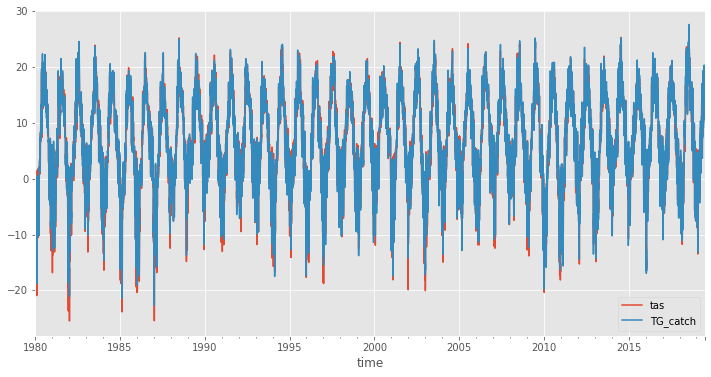

In [9]:
temp_df.plot(figsize=(12, 6))

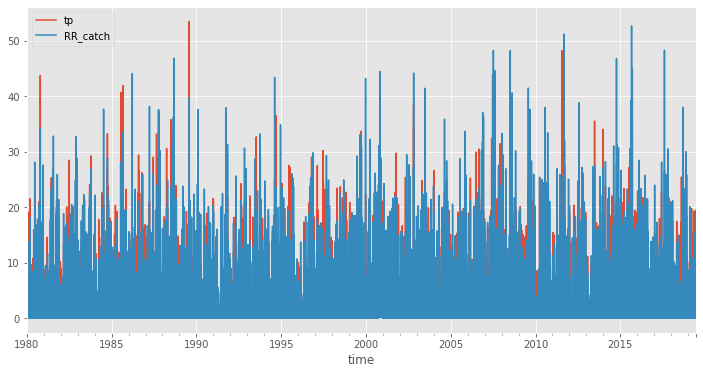

In [10]:
pptn_df.plot(figsize=(12, 6))

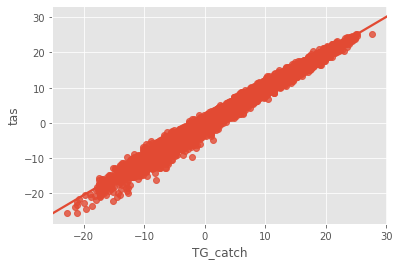

In [11]:
sn.regplot(x='TG_catch', y='tas', data=df)

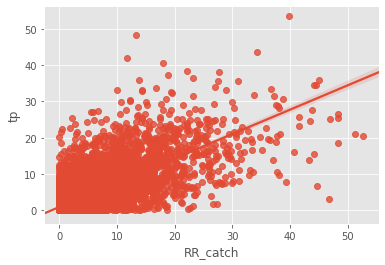

In [12]:
sn.regplot(x='RR_catch', y='tp', data=df)

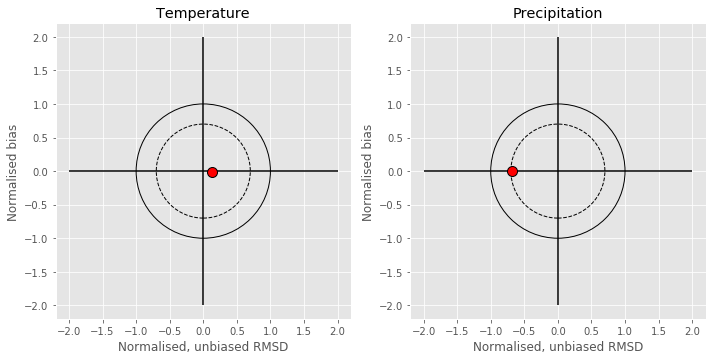

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 15), subplot_kw={'aspect':'equal'})
target_plot(df['tas'], df['TG_catch'], ax=axes[0], title='Temperature')
target_plot(df['tp'], df['RR_catch'], ax=axes[1], title='Precipitation')
plt.tight_layout()